In [53]:
# Import PyTorch, image tools, plotting, and evaluation libraries
import os, glob, numpy as np
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    precision_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

In [54]:
# Base path to your dataset folder (the one that contains COVID, Normal, etc.)
base_path = "/Users/hatemelgenedy/Desktop/AI and Data Science Microsoft course/COVID-19_Radiography_Dataset 2"

# Check that folder exists and print contents
print("Base path exists?", os.path.exists(base_path))
print("Contents:", os.listdir(base_path))

Base path exists? True
Contents: ['Lung_Opacity.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx', '.DS_Store', 'Viral Pneumonia', 'COVID.metadata.xlsx', 'Normal.metadata.xlsx', 'Lung_Opacity', 'Normal', 'COVID', 'README.md.txt']


In [55]:
# Connect each class name to its folder in the dataset
data_dirs = {
    'Normal': os.path.join(base_path, "Normal"),
    'Lung Opacity': os.path.join(base_path, "Lung_Opacity"),
    'COVID-19': os.path.join(base_path, "COVID"),
    'Viral Pneumonia': os.path.join(base_path, "Viral Pneumonia"),
}

# Show whether all folders exist
for k, v in data_dirs.items():
    print(k, "->", os.path.exists(v))

Normal -> True
Lung Opacity -> True
COVID-19 -> True
Viral Pneumonia -> True


In [57]:
# Loads images from folders, assigns labels, and ignores segmentation masks (files containing "mask").
class RadiographyDataset(Dataset):
    def __init__(self, data_dirs, transform=None):
        self.transform = transform
        self.images, self.labels = [], []

        # Assign numeric labels for each class.
        self.class_to_idx = {
            'COVID-19': 0,
            'Normal': 1,
            'Viral Pneumonia': 2,
            'Lung Opacity': 3
        }

        # Define loading order.
        dirs = [
            data_dirs['COVID-19'],
            data_dirs['Normal'],
            data_dirs['Viral Pneumonia'],
            data_dirs['Lung Opacity']
        ]
        classes = ['COVID-19', 'Normal', 'Viral Pneumonia', 'Lung Opacity']

        exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tif")

        # Loop through folders and load valid X-ray images.
        for folder, cls in zip(dirs, classes):
            print("\nLoading:", cls)
            before = len(self.images)

            for ext in exts:
                for img_path in glob.glob(os.path.join(folder, "**", ext), recursive=True):

                    # Skip mask images (not actual X-rays)
                    if "mask" in os.path.basename(img_path).lower():
                        continue

                    # Add image path and its class label
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[cls])

            print("Found:", len(self.images) - before, "images")

    def __len__(self):
        # Total number of images in dataset.
        return len(self.images)

    def __getitem__(self, idx):
        # Read image and apply transforms.
        img = Image.open(self.images[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [58]:
 # Resize images, convert to tensors, and normalize using ImageNet mean/std (required by ResNet18).
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Create the dataset object with transforms.
dataset = RadiographyDataset(data_dirs=data_dirs, transform=transform)
print("\nTotal images loaded:", len(dataset))


Loading: COVID-19
Found: 7232 images

Loading: Normal
Found: 20384 images

Loading: Viral Pneumonia
Found: 2690 images

Loading: Lung Opacity
Found: 12024 images

Total images loaded: 42330


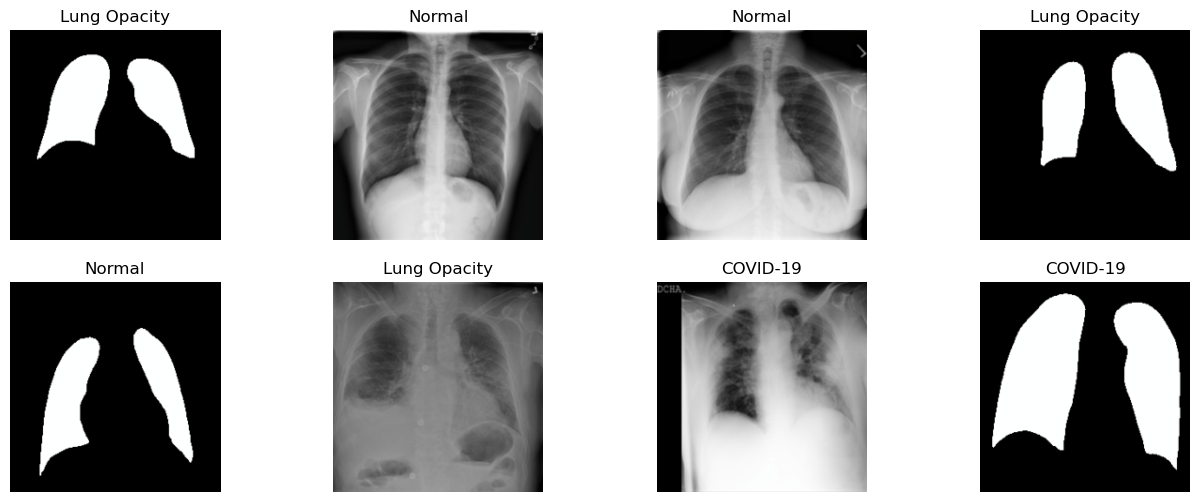

In [59]:
# Undo normalization so images look normal when plotted.
def unnormalize(img):
    img = img.permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    return img.clip(0, 1)

# Display random images from the dataset to verify correct loading.
def show_random_xrays(dataset, n=8):
    idxs = np.random.choice(len(dataset), n, replace=False)
    plt.figure(figsize=(16, 6))
    class_names = ['COVID-19', 'Normal', 'Viral Pneumonia', 'Lung Opacity']

    for j, i in enumerate(idxs):
        img, label = dataset[i]
        plt.subplot(2, n//2, j+1)
        plt.imshow(unnormalize(img), cmap="gray")
        plt.title(class_names[label])
        plt.axis("off")

    plt.show()

show_random_xrays(dataset)

In [60]:
# Split 80% of data for training and 20% for testing.
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders to feed the model in batches.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 33864
Test samples: 8466


In [61]:
# Select GPU if available, otherwise use CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# Load ResNet18 pretrained on ImageNet.
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Replace final layer with output of size 4 (for 4 classes).
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)

# Set loss function and optimizer for training.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Using: cpu


In [62]:
# One training step: forward pass, compute loss, backprop, weight update.
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    preds_list, labels_list = [], []

    for imgs, labels in tqdm(loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds_list.extend(outputs.argmax(1).cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

    return total_loss / len(loader.dataset), accuracy_score(labels_list, preds_list)


# Evaluation step: no training, only measure accuracy and loss.
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    preds_list, labels_list, prob_list = [], [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Evaluating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            total_loss += criterion(outputs, labels).item() * imgs.size(0)
            prob_list.extend(F.softmax(outputs, dim=1).cpu().numpy())
            preds_list.extend(outputs.argmax(1).cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    return total_loss / len(loader.dataset), accuracy_score(labels_list, preds_list), np.array(labels_list), np.array(preds_list), np.array(prob_list)

In [ ]:
# Train for several epochs and save the model with best accuracy.
num_epochs = 10
best_acc = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, y_true, y_pred, y_prob = evaluate(model, test_loader, criterion, device)

    print(f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f}")
    print(f"Test  Loss={test_loss:.4f}, Acc={test_acc:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "best_resnet18_covid.pth")
        print("Best model saved! New best acc =", best_acc)


Epoch 1/10


Training:  17%|█▋        | 90/530 [45:20<4:12:38, 34.45s/it]